In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from get_stations_ts import get_station
import cartopy.crs as ccrs
import cartopy.feature as cfeat

In [82]:
FILES = {"SM2RAIN": {'path': '/opt/data/SM2RAIN-ASCAT/SM2RAIN-ASCAT_Rprocessed.IP.nc', 'varname': 'rainfall'},
         "ERA5": {'path':'/opt/data/ERAIN/IP-tp-2008-2017.daysum.nc', 'varname': 'tp'}, 
         "NCEP2": {'path':'/opt/data/NCEP2/prate.sfc.IP.2011-2017.nc', 'varname': 'prate'},
         "EOBS": {'path':'/opt/data/EOBS/rr_0.25deg_reg_v17.0.IP.nc', 'varname': 'rr'},
        "CHIRPS": {'path':'/opt/data/CHIRP/chirps-v2.0.IP.2011-2017.nc', 'varname': 'precip'}}

DATASET_LABEL = 'SM2RAIN'
ID_STATION = 8
FILEPATH = FILES[DATASET_LABEL]['path']

ds = xr.open_dataset(FILEPATH)

#tp_clim = ds.groupby('time.dayofyear').mean(dim='time')
#tp_anom = ds.groupby('time.dayofyear') - tp_clim


/Users/matteodefelice/miniconda2/envs/py36/lib/python3.6/site-packages/xarray/conventions.py:537: SerializationWarning: variable 'rainfall' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [83]:
ds

<xarray.Dataset>
Dimensions:   (lat: 81, lon: 121, time: 4018)
Coordinates:
  * lon       (lon) float64 -10.0 -9.875 -9.75 -9.625 -9.5 -9.375 -9.25 ...
  * lat       (lat) float64 35.0 35.12 35.25 35.38 35.5 35.62 35.75 35.88 ...
  * time      (time) datetime64[ns] 2007-01-01 2007-01-02 2007-01-03 ...
Data variables:
    rainfall  (time, lat, lon) float32 ...
Attributes:
    Origin:       NetCDF file created by loadeR.2nc: https://github.com/Santa...
    Conventions:  CF-1.4

In [84]:
d = get_station(ID_STATION)
d.head()
slice(d.date.iloc[0], d.date.iloc[-1])

slice(Timestamp('2013-11-28 00:00:00'), Timestamp('2017-12-31 00:00:00'), None)

In [85]:
if DATASET_LABEL=='NCEP2':
    st_ds = ds.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).stack(x = ('lat','lon')) #NCEP2
elif DATASET_LABEL=='CHIRPS':
            st_ds = ds.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).stack(x = ('latitude','longitude')) #CHIRPS        
elif DATASET_LABEL=='ERA5':
    ds.time.values = ds.time.values.astype('datetime64[D]') # truncate to day
    st_ds = ds.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).drop('time_bnds').stack(x = ('latitude','longitude')) # ERA5
elif DATASET_LABEL=='EOBS':
    st_ds = ds.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).stack(x = ('latitude','longitude')) #EOBS
elif DATASET_LABEL=='SM2RAIN':
    st_ds = ds.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).stack(x = ('lat','lon')) #EOBS



In [86]:
print(d.shape)
#d = d[(d.date >= st_ds.time.values[0]) & (d.date <= st_ds.time.values[-1])]
#print(st_ds.prate.values.shape)
st_ds.time.values[-1]

(1495, 7)


numpy.datetime64('2017-12-31T00:00:00.000000000')

In [87]:
def pt_corr(x):
            target = d.value.values 
            
            if False: ## (not np.isnan(target).any()):
                if DATASET_LABEL=='NCEP2':
                    cf = np.corrcoef(x.prate.values[:,0], target)[0,1] # NCEP2
                elif DATASET_LABEL=='CHIRPS':
                    cf = np.corrcoef(x.precip.values, target)[0,1] # CHIRPS
                elif DATASET_LABEL=='ERA5':
                    cf = np.corrcoef(x.tp.values[:,0], target)[0,1] # ERA5
                elif DATASET_LABEL=='SM2RAIN':
                    cf = np.corrcoef(x.rainfall.values, target)[0,1] # SM2RAIN
                elif DATASET_LABEL=='EOBS':
                    xm = np.ma.masked_array(x.rr.values, np.isnan(x.rr.values)) #EOBS
                    ym = np.ma.masked_array(target,np.isnan(target))
                    m  = ~(xm.mask|ym.mask)
                    cf = np.corrcoef(x.rr.values[m], target[m],)[0,1]
            else:
                if DATASET_LABEL=='ERA5':
                    xm = np.ma.masked_array(x.tp.values[:,0], np.isnan(x.tp.values[:,0])) #ERA5
                    ym = np.ma.masked_array(target,np.isnan(target))
                    m  = ~(xm.mask|ym.mask)
                    cf = np.corrcoef(x.tp.values[:,0][m], target[m],)[0,1]
                elif DATASET_LABEL=='CHIRPS':
                    xm = np.ma.masked_array(x.precip.values, np.isnan(x.precip.values)) #ERA5
                    ym = np.ma.masked_array(target,np.isnan(target))
                    m  = ~(xm.mask|ym.mask)
                    cf = np.corrcoef(x.precip.values[m], target[m],)[0,1]
                elif DATASET_LABEL=='SM2RAIN':
                    xm = np.ma.masked_array(x.rainfall.values, np.isnan(x.rainfall.values)) #ERA5
                    ym = np.ma.masked_array(target,np.isnan(target))
                    m  = ~(xm.mask|ym.mask)
                    cf = np.corrcoef(x.rainfall.values[m], target[m],)[0,1]


                elif DATASET_LABEL=='NCEP2':
                    xm = np.ma.masked_array(x.prate.values[:,0], np.isnan(x.prate.values[:,0])) #ERA5
                    ym = np.ma.masked_array(target,np.isnan(target))
                    m  = ~(xm.mask|ym.mask)
                    cf = np.corrcoef(x.prate.values[:,0][m], target[m],)[0,1]
                elif DATASET_LABEL=='EOBS':
                    xm = np.ma.masked_array(x.rr.values, np.isnan(x.rr.values)) #EOBS
                    ym = np.ma.masked_array(target,np.isnan(target))
                    m  = ~(xm.mask|ym.mask)
                    cf = np.corrcoef(x.rr.values[m], target[m],)[0,1]

           
            if np.isnan(cf):
                return(xr.DataArray(-1))
            else:
                return(xr.DataArray(cf))

        
cm = st_ds.groupby('x').apply(pt_corr)
cm = cm.unstack('x')


/Users/matteodefelice/miniconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/matteodefelice/miniconda2/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/matteodefelice/miniconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/matteodefelice/miniconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/matteodefelice/miniconda2/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)


In [88]:
cm

<xarray.DataArray (lat: 81, lon: 121)>
array([[-1.      , -1.      , -1.      , ..., -0.016491, -0.0282  , -0.014324],
       [-1.      , -1.      , -1.      , ..., -0.025753, -0.03548 , -0.03548 ],
       [-1.      , -1.      , -1.      , ..., -0.033078, -0.030888, -0.030888],
       ...,
       [-1.      , -1.      , -1.      , ...,  0.222108,  0.185793,  0.166999],
       [-1.      , -1.      , -1.      , ...,  0.209759,  0.174586,  0.156122],
       [-1.      , -1.      , -1.      , ...,  0.198274,  0.168326,  0.149189]])
Coordinates:
  * lat      (lat) float64 35.0 35.12 35.25 35.38 35.5 35.62 35.75 35.88 ...
  * lon      (lon) float64 -10.0 -9.875 -9.75 -9.625 -9.5 -9.375 -9.25 ...

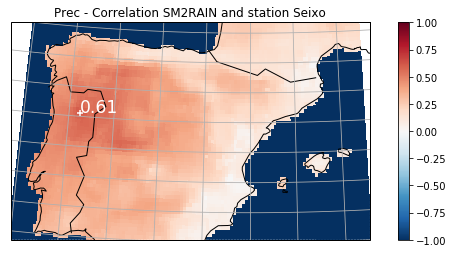

In [89]:
fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.Orthographic(0, 35))
# cm.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels = 23)
cm.plot(ax=ax, transform=ccrs.PlateCarree())
# add maximum
max_corr = cm.max()
if (DATASET_LABEL=='NCEP2') or (DATASET_LABEL=='ERA5'):
    x_max = cm.where(cm == cm.max(), drop = True).x_level_1
    y_max = cm.where(cm == cm.max(), drop = True).x_level_0
else:
    x_max = cm.where(cm == cm.max(), drop = True).lon
    y_max = cm.where(cm == cm.max(), drop = True).lat
ax.scatter(x = x_max.values[0], y = y_max.values[0], color='white', marker='+', transform=ccrs.PlateCarree())
ax.annotate(str(round(float(max_corr.values), 2)), xy = (x_max.values[0], y_max.values[0]), xycoords = ccrs.PlateCarree()._as_mpl_transform(ax), color = 'white', fontsize = 'xx-large')
plt.title('Prec - Correlation ' + DATASET_LABEL + ' and station ' + d.station.iloc[0])
ax.set_global(); 
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(cfeat.BORDERS);
ax.add_feature(cfeat.RIVERS);#ax.relim(); ax.autoscale_view()
ax.set_extent([-10, 5, 37, 44]); ax.gridlines()
plt.savefig(str('prec_corr_' + DATASET_LABEL + '-stn' + d.station.iloc[0]+ '.png'), dpi = 300)



AttributeError: 'Dataset' object has no attribute 'precip'

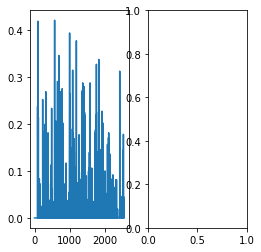

In [33]:
# Try scatter
#fig, axes = plt.subplots(ncols=3)

target = d.value.values
plt.subplot(131)
plt.plot(target)
plt.subplot(132)
ds.precip.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).sel(longitude = x_max, latitude = y_max, method='nearest').plot()
# NCEP x = ds.prate.sel(lon = x_max, lat = y_max, method='nearest').values
# EOBS x = ds.rr.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).sel(longitude = x_max, latitude = y_max, method='nearest')
x = ds.precip.sel(time = slice(d.date.iloc[0], d.date.iloc[-1])).sel(longitude = x_max, latitude = y_max, method='nearest')
plt.subplot(133)
plt.scatter(x = target, y = x[:,0])
# np.corrcoef(target, x[:,0,0])

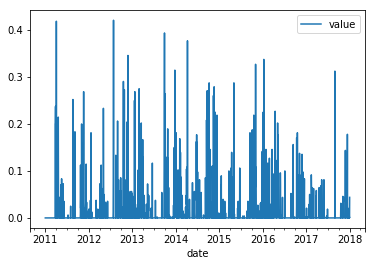

(array([8.879429e+07, 1.071749e+06, 1.749480e+05, 3.783000e+04,
        9.318000e+03, 2.049000e+03, 4.080000e+02, 1.160000e+02,
        5.700000e+01, 1.600000e+01]),
 array([  0.        ,  26.82405396,  53.64810791,  80.47216187,
        107.29621582, 134.12026978, 160.94432373, 187.76837769,
        214.59243164, 241.4164856 , 268.24053955]),
 <a list of 10 Patch objects>)

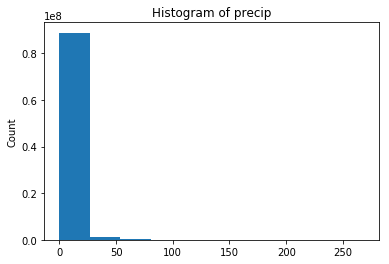